# English Vocab

![](img/english-vocab.jpg)

Apr, 2024

> Vector database, Hierarchical clustering


## Background
For a few years now, I regularly jot down on a spreadsheet unknown English words or terms that I want to remember. I do this especially when I read articles from the BBC and SkyNews. The idea is to later refer back to this list to refresh my vocabulary, although I rarely do so afterwards.

It occurred to me that instead of just taking a cold glance at the list, it would be more engaging to create a program that shows random words from it before showing me their meanings. Perhaps this would motivate me to revisit them.

Then I recalled that a word list is essentially a set of data and that I could analyze it. For instance, to investigate the frequency of use of the words in it. I often wonder if the word I'm looking up in the dictionary is worth the effort of learning, because it might be rare, archaic, or very specific to a certain field. I thought it would be good to contrast my list with another one with information about word frequencies in current English.

Finally, I thought about clustering words as a method to facilitate learning. Instead of keeping a whole unordered list, it could be interesting to group terms based on their meaning. In this sense, I could use semantic word vectorization and then a clustering algorithm to see if I could get results that would be helpful.

So off I went with the project!

## The data
I keep the list of words and their meanings in a CSV file, so I directly load them into a pandas dataframe.

In [1]:
import random

import chromadb
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.manifold import TSNE

# Read file with English vocabulary
vocab = pd.read_csv("data/english-vocab.csv")

# # Look for duplicates
# vocab.loc[vocab.duplicated(subset="word"), :]

vocab

,word,meaning
0,primeval,"'primitivo, primigenio.', 'Will we soon find p..."
1,pigtails,"'coletas, trenzas.', 'She combed her hair into..."
2,pare,"'fruit: peel, pelar, mondar.', 'You need to pa..."
3,pang,'punzada de dolor'
4,outwit,'outsmart'
...,...,...
1689,negligee,woman's sheer nightdress.
1690,paltry,"small or not enough, insignificant."
1691,pied,having two or more different colours.
1692,pilfer,steal in small amounts


## A simple app for looking up words
I used the Gradio library to implement a simple web application. The app gets a random word from the list to guess and provides its meaning upon request.

In [2]:
# gradio app demo
with gr.Blocks() as demo:
    # Components
    file = gr.File()
    df = gr.Dataframe(visible=False)

    with gr.Row():
        button_getword = gr.Button("Get word", scale=0)
        textbox_word = gr.Textbox(label="word")

    with gr.Row():
        button_getmeaning = gr.Button("Get meaning", scale=0)
        textbox_meaning = gr.Textbox(label="meaning")

    # Events

    def on_file_upload(file):
        words = pd.read_csv(file)
        return words

    file.upload(
        fn=on_file_upload,
        inputs=file,
        outputs=df,
    )

    def on_getword_button(df):
        chosen_word = random.choice(df["word"])
        return chosen_word, gr.Textbox(value="")

    button_getword.click(
        fn=on_getword_button,
        inputs=df,
        outputs=[textbox_word, textbox_meaning],
    )

    def on_getmeaning_button(df, chosen_word):
        return df.loc[df["word"] == chosen_word, "meaning"].iloc[0]

    button_getmeaning.click(
        fn=on_getmeaning_button,
        inputs=[df, textbox_word],
        outputs=textbox_meaning,
    )

# demo.launch() # <- does not work in Jupyter Book

![](img/english-vocab.gif)

(This is just a GIF animation of the app. You can access the app [here](https://huggingface.co/spaces/datuz/english-vocab). You will need a CSV file to test it out, with two columns, the first one with the header `word` and the second one with the header `meaning`.)

## Frequency of unigram words
From Kaggle I downloaded the [⅓ Million Most Frequent English Words on the Web](https://www.kaggle.com/datasets/rtatman/english-word-frequency) dataset.

This dataset contains the counts of the 333,333 most commonly-used single words on the English language web, as derived from the Google Web Trillion Word Corpus.

In [3]:
# ⅓ Million Most Frequent English Words on the Web
unigram_freq = pd.read_csv("data/unigram_freq.csv", usecols=["word"])

# Use the index to get the raking position
unigram_freq = unigram_freq.reset_index().rename(columns={"index": "pos"})
unigram_freq

,pos,word
0,0,the
1,1,of
2,2,and
3,3,to
4,4,a
...,...,...
333328,333328,gooek
333329,333329,gooddg
333330,333330,gooblle
333331,333331,gollgo


I merged this dataset with my vocabulary dataframe in a way that I ended up only with _single words_ (unigram) ranked according to their frequency in the web.

In [4]:
# With "inner" merge only unigram and listed words considered
vocab_freq = vocab.merge(unigram_freq, how="inner", on="word").sort_values(by="pos")
vocab_freq

,word,meaning,pos
767,august,"'agosto / prestigioso, augusto'",559
929,mar,"'to damage or spoil sth good, dañar, estropear...",771
124,jack,"'device used to lift a vehicle, gato.', 'Dan g...",1764
1376,scale,báscula / escala / escama,1776
271,apparel,"'clothing, when it is being sold in shops/stor...",2004
...,...,...,...
995,draughty,"'con corrientes de aire (US: drafty)', '', ""UK...",289427
1139,arraign,"culpar, encausar, to formally accuse someone i...",297458
189,fluster,"'agitate, confuse, aturdir, aturullar.', 'The ...",301422
550,lambast,"'attack verbally, arremeter contra', 'My boss ...",304390


Then I plotted the position of my words on a histogram to check their location in terms of frequency.

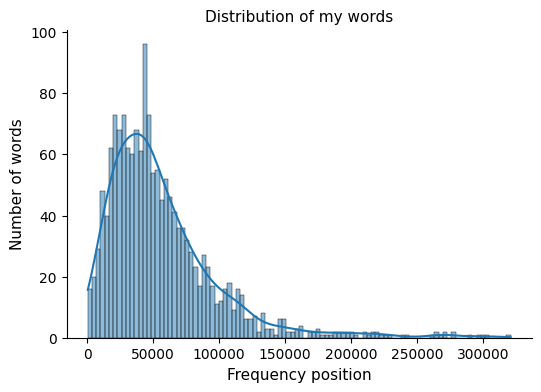

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(vocab_freq["pos"], ax=ax, bins=100, kde=True)

ax.set_title("Distribution of my words", fontsize=11)
ax.set_xlabel("Frequency position", fontsize=11)
ax.set_ylabel("Number of words", fontsize=11)

sns.despine()

plt.show()

So most of the words in my list are around the position of 40,000 in terms of frequency of appearance on the web. With the peak of this distribution further to the left, the level of English proficiency may be lower. In my case, it feels like the words I record are not within the range of the most common, nor within the range of the rarest.

## Embeddings and clustering
I was drawn to the idea of grouping words to organize my list of over fifteen hundred vocabulary words.

For example, in English I come across a large number of words to refer to a crazy person or a fool, or to describe emotions like happiness or a state of sadness. Also, I find a lot of vocabulary associated with specific fields, for example, the world of dogs comes to mind now. Wouldn't it be a good idea to associate these terms into groups? It would leave me with a much more organized and easier-to-digest list.

So, I first vectorized each word to parameterize them semantically. I did this using the [Chroma](https://www.trychroma.com/) open-source vector database.

In [6]:
# Define words and ids to be inserted in the vector db
words = vocab_freq["word"].tolist()
ids = [str(element) for element in list(range(len(words)))]

# Connect to the vector database
client_chromadb = chromadb.PersistentClient(path="chromadb/")

# OpenAI API key
api_key = "your-api-key"

# # Create a new collection
# collection = client_chromadb.create_collection(
#     name="word_collection",
#     embedding_function=OpenAIEmbeddingFunction(api_key=api_key,
#                                                model_name="text-embedding-ada-002")
# )

# Retrieve an already created colletion
collection = client_chromadb.get_collection(
    name="word_collection", embedding_function=OpenAIEmbeddingFunction(api_key=api_key)
)

# # Inspect the collection
# collection.count()

# # Delete collection
# collection.delete(ids=ids)

# # Insert embeddings -embeddings are created by the collection
# collection.add(
#     ids=ids,
#     documents=words
# )

# Retrieve embeddings
n = len(words)
embeddings = collection.peek(n)["embeddings"]

I performed the hierarchical/agglomerative clustering and plotted a (very large, sorry!) dendrogram to visualize results.

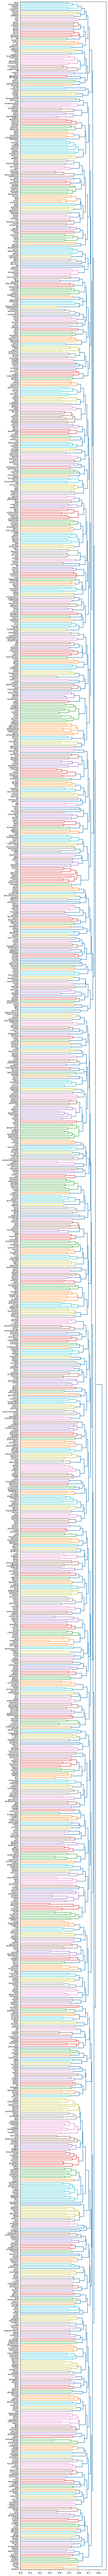

In [7]:
# Perform hierarchical/agglomerative clustering
mergings = linkage(embeddings, method="complete")

# Plot dendrogram
fig, ax = plt.subplots(figsize=(6, 180))
dendrogram(
    mergings,
    ax=ax,
    labels=words,
    leaf_rotation=0,
    leaf_font_size=8,
    orientation="right",
    color_threshold=0.6,
)
plt.show()

I can't draw any conclusion from this dendrogram! Word clustering seems to me random. The only thing it's useful for is determining the threshold to obtain a specific number of clusters.

In [8]:
# Select cluster defining threshold taking a look at the dendrogram
cluster_threshold = 0.75

# Extract cluster labels
labels = fcluster(mergings, cluster_threshold, criterion="distance")

# Print how many clusters we have selected
print(
    f"According to selected {cluster_threshold} threshold we have defined {len(set(labels))} clusters."
)

According to selected 0.75 threshold we have defined 5 clusters.


And this is the two-dimensional map I obtained for this number of clusters.

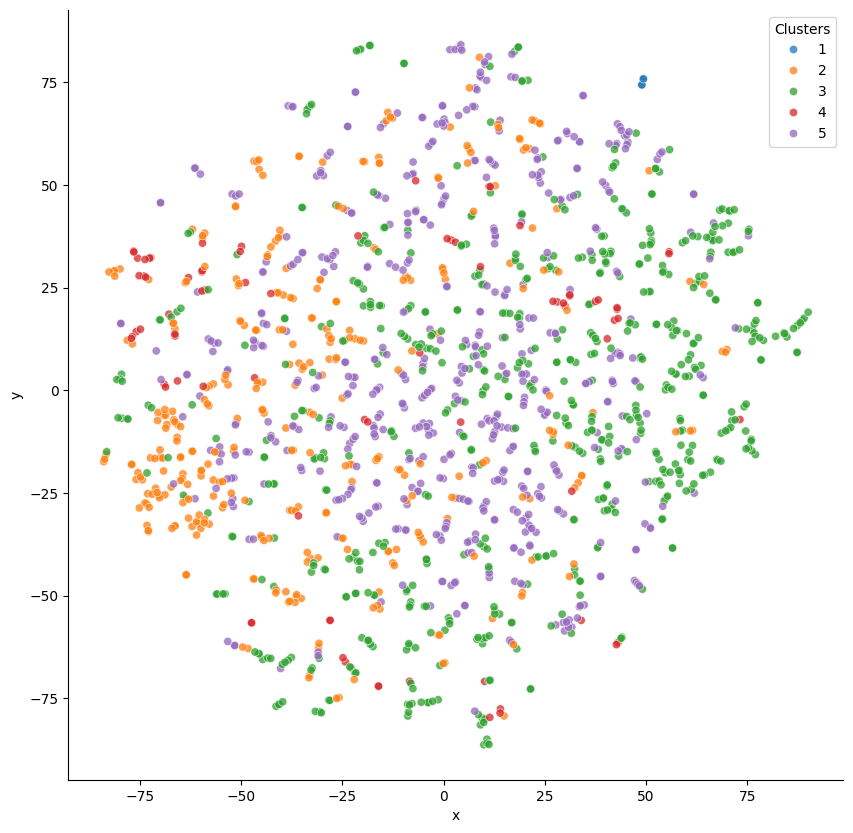

In [9]:
# Reduce the number of embeddings dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Create an auxiliary dataframe to plot
df_viz = pd.DataFrame(embeddings_2d.tolist()).rename(columns={0: "x", 1: "y"})
df_viz["word"] = words
df_viz["label"] = labels

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    ax=ax, x="x", y="y", hue="label", data=df_viz, palette="tab10", alpha=0.75
)
add = 0.1
# for index, row in df_viz.iterrows():
#     ax.text(row["x"] + add, row["y"] + add, row["word"], color="grey")

ax.legend(title="Clusters")
sns.despine()
plt.show()

I couldn't draw any clear conclusions regarding group differentiation.

Was the algorithm working correctly? Was the word vectorization accurate? I decided to test it with a smaller and simpler group of words.

How would the algorithm hierarchically group this set of animal-related vectorized words? `human`, `ape`, `snake`, `lizard`, `sheep`, `lamb`, `goat`, `hen`, `rooster`, `cow`, `calf`, `ox`, `horse`, `foal`, `dog`, `cat`, `eagle`, `duck`

In [15]:
# Define list of animals
animals = [
    "human",
    "ape",
    "snake",
    "lizard",
    "sheep",
    "lamb",
    "goat",
    "hen",
    "rooster",
    "cow",
    "calf",
    "ox",
    "horse",
    "foal",
    "dog",
    "cat",
    "eagle",
    "duck",
]

# Shuffle the list (just in case)
random.shuffle(animals)

In [16]:
# Define words and ids to be inserted in the vector db
words = animals
ids = [str(element) for element in list(range(len(animals)))]

# # Create a new collection
# collection = client_chromadb.create_collection(
#     name="animal_collection",
#     embedding_function=OpenAIEmbeddingFunction(api_key=api_key,
#                                                model_name="text-embedding-ada-002")
# )

# Retrieve an already created colletion
collection = client_chromadb.get_collection(
    name="animal_collection",
    embedding_function=OpenAIEmbeddingFunction(api_key=api_key),
)

# # Inspect the collection
# collection.count()

# # Delete collection
# collection.delete(ids=ids)

# # Insert embeddings -embeddings are created by the collection
# collection.add(
#     ids=ids,
#     documents=words
# )

# Retrieve embeddings
n = len(words)
embeddings = collection.peek(n)["embeddings"]

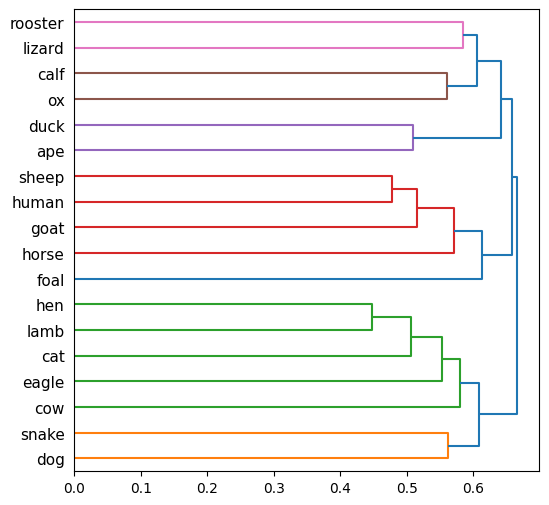

In [17]:
# Perform hierarchical/agglomerative clustering
mergings = linkage(embeddings, method="complete")

# Plot dendrogram
fig, ax = plt.subplots(figsize=(6, 6))
dendrogram(
    mergings,
    ax=ax,
    labels=words,
    leaf_rotation=0,
    leaf_font_size=11,
    orientation="right",
    color_threshold=0.6,
)
plt.show()

Doesn't quite work either!

In [13]:
# Select cluster defining threshold taking a look at the dendrogram
cluster_threshold = 0.6

# Extract cluster labels
labels = fcluster(mergings, cluster_threshold, criterion="distance")

# Print how many clusters we have selected
print(
    f"According to selected {cluster_threshold} threshold we have defined {len(set(labels))} clusters."
)

According to selected 0.6 threshold we have defined 7 clusters.


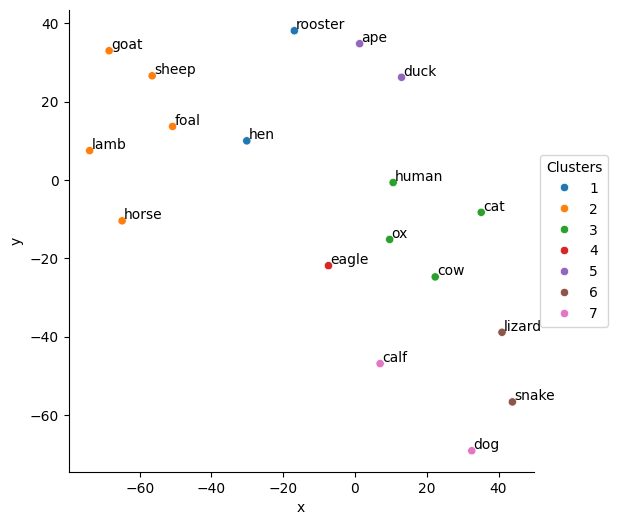

In [14]:
# Reduce the number of embeddings dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Create an auxiliary dataframe to plot
df_viz = pd.DataFrame(embeddings_2d.tolist()).rename(columns={0: "x", 1: "y"})
df_viz["word"] = words
df_viz["label"] = labels

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(ax=ax, x="x", y="y", hue="label", data=df_viz, palette="tab10")
add = 0.5
for index, row in df_viz.iterrows():
    ax.text(row["x"] + add, row["y"] + add, row["word"])

ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10, title="Clusters")
sns.despine()
plt.show()

These clusters do not make sense.

I decided to ask ChatGPT what was going on:

![](img/ChatGPT.png)

I'll stick with this -> 
_If your word embeddings are not fine-tuned for your specific task, they may not perform well for clustering._

## Conclusion

I had believed that the sole semantic vectorization of individual words would provide me with coherent groupings, but it turns out to be more complicated. I realize my naivety now that I've tried it and haven't managed to organize my messy list into meaningful categories. I understand that it would be necessary to adjust the model by training it according to the type of organization I would be interested in.

Indeed, what I was aiming for was too much to ask. Sometimes I forget that, despite being amazing, AI cannot perform miracles.